![image.png](attachment:image.png)

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from IPython.display import HTML

In [2]:
df = pd.read_pickle('base_nfp.pkl')

In [3]:
df.isna().sum()

CNPJ emit.               0
Emitente                 0
No.                      0
Data Emissão             0
Valor NF                 0
Data Registro            0
Créditos                 0
Situação do Crédito      0
Ano                      0
Semestre                 0
Retorno                980
flag_credito             0
categoria                0
dtype: int64

In [4]:
df ['Retorno'] = df ['Retorno'].fillna(0)

In [5]:
df.isna().sum()

CNPJ emit.             0
Emitente               0
No.                    0
Data Emissão           0
Valor NF               0
Data Registro          0
Créditos               0
Situação do Crédito    0
Ano                    0
Semestre               0
Retorno                0
flag_credito           0
categoria              0
dtype: int64

## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

## Criação das Variáveis Temporais:

### Criando um dicionário para tradução e conversão das datas:

In [6]:
dias_ptbr = {'Sunday' : 'Domingo',
             'Monday' :'Segunda-feira',
             'Tuesday' : 'Terça-feira',
             'Wednesday' : 'Quarta-feira',
             'Thursday' : 'Quinta-feira',
             'Friday' : 'Sexta-feira',
             'Saturday' : 'Sábado'}

meses_ptbr = {'January':'Janeiro',
              'February':'Fevereiro',
              'March':'Março',
              'April':'Abril',
              'May':'Maio',
              'June':'Junho',
              'July':'Julho',
              'August':'Agosto',
              'September':'Setembro',
              'October':'Outubro',
              'November':'Novembro',
              'December':'Dezembro'}

meses_numeral = {'January': 1,
              'February':2,
              'March':3,
              'April':4,
              'May':5,
              'June':6,
              'July':7,
              'August':8,
              'September':9,
              'October':10,
              'November':11,
              'December':12}

Usando dt com replace para traduzir os meses e dias da semana:

In [7]:
df['Data Emissão'].dt.day_name().replace(dias_ptbr)
df['Data Emissão'].dt.month_name().replace(meses_ptbr)

0           Junho
1           Junho
2           Junho
3           Junho
4           Junho
           ...   
187641    Janeiro
187642    Janeiro
187643    Janeiro
187644    Janeiro
187645    Janeiro
Name: Data Emissão, Length: 187646, dtype: object

### Criando as colunas com as novas variáveis usando o .dt para selecionar meses, dias do mês, semana e trimestre:

In [8]:
df['trimestre'] = df['Data Emissão'].dt.quarter
df['dia_da_semana'] = df['Data Emissão'].dt.day_name().replace(dias_ptbr)
df['dia_da_semana_numeral'] = df['Data Emissão'].dt.dayofweek
df['mês'] = df['Data Emissão'].dt.month_name().replace(meses_numeral)
df['dia_do_mês'] = df['Data Emissão'].dt.day
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria,trimestre,dia_da_semana,dia_da_semana_numeral,mês,dia_do_mês
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado,2,Sexta-feira,4,6,30
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto,2,Sexta-feira,4,6,30
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes,2,Sexta-feira,4,6,30
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes,2,Sexta-feira,4,6,30
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes,2,Sexta-feira,4,6,30


### Laço for com condição para transformar str em int, nos dias úteis e fins de semana:

In [9]:
for dias in df['dia_da_semana']:
  if (dias == 'Segunda-feira'):
      df['dia_útil'] = 1
  elif(dias == 'Terça-feira'):
      df['dia_útil'] = 1
  elif(dias == 'Quarta-feira'):
      df['dia_útil'] = 1
  elif(dias == 'Quinta-feira'):
      df['dia_útil'] = 1
  elif(dias == 'Sexta-feira'):
      df['dia_útil'] = 1
  else:
      df['dia_útil'] = 0

df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria,trimestre,dia_da_semana,dia_da_semana_numeral,mês,dia_do_mês,dia_útil
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado,2,Sexta-feira,4,6,30,1
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto,2,Sexta-feira,4,6,30,1
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes,2,Sexta-feira,4,6,30,1
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes,2,Sexta-feira,4,6,30,1
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes,2,Sexta-feira,4,6,30,1


In [10]:
for dias in df['dia_da_semana']:
  if (dias == 'Sábado'):
      df['fim_de_semana'] = 1
  if (dias == 'Domingo'):
      df['fim_de_semana'] = 1
  else:
      df['fim_de_semana'] = 0

df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria,trimestre,dia_da_semana,dia_da_semana_numeral,mês,dia_do_mês,dia_útil,fim_de_semana
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado,2,Sexta-feira,4,6,30,1,0
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto,2,Sexta-feira,4,6,30,1,0
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes,2,Sexta-feira,4,6,30,1,0
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes,2,Sexta-feira,4,6,30,1,0
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes,2,Sexta-feira,4,6,30,1,0


### Agregando os Valores das Notas com o QCUT:

In [11]:
df['Q_5'] = pd.qcut(df['Valor NF'], q=5)
df['Q_10'] = pd.qcut(df['Valor NF'], q=10)
df['Q_20'] = pd.qcut(df['Valor NF'], q=20)
df['Q_50'] = pd.qcut(df['Valor NF'], q=50)
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,...,dia_da_semana,dia_da_semana_numeral,mês,dia_do_mês,dia_útil,fim_de_semana,Q_5,Q_10,Q_20,Q_50
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(13.36, 28.61]","(20.29, 28.61]","(24.5, 28.61]","(23.62, 25.14]"
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(28.61, 55.0]","(38.88, 55.0]","(46.028, 55.0]","(48.0, 50.72]"
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(13.36, 28.61]","(20.29, 28.61]","(24.5, 28.61]","(26.9, 28.61]"
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(55.0, 131.36]","(81.8, 131.36]","(101.48, 131.36]","(107.04, 119.5]"
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(55.0, 131.36]","(81.8, 131.36]","(101.48, 131.36]","(119.5, 131.36]"


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

### Função para calcular o Information Value:

In [27]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    coringa = 0.00001
    tab['woe'] = np.log(tab.pct_evento+coringa/tab.pct_nao_evento+coringa)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

iv = IV(df.Q_50, df.flag_credito)
iv

0.05714347149606773

### Eliminando algumas variáveis indejesadas:

In [13]:
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,...,dia_da_semana,dia_da_semana_numeral,mês,dia_do_mês,dia_útil,fim_de_semana,Q_5,Q_10,Q_20,Q_50
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(13.36, 28.61]","(20.29, 28.61]","(24.5, 28.61]","(23.62, 25.14]"
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(28.61, 55.0]","(38.88, 55.0]","(46.028, 55.0]","(48.0, 50.72]"
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(13.36, 28.61]","(20.29, 28.61]","(24.5, 28.61]","(26.9, 28.61]"
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(55.0, 131.36]","(81.8, 131.36]","(101.48, 131.36]","(107.04, 119.5]"
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(55.0, 131.36]","(81.8, 131.36]","(101.48, 131.36]","(119.5, 131.36]"


In [14]:
df_1 = pd.DataFrame(df)

In [15]:
df_1.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,...,dia_da_semana,dia_da_semana_numeral,mês,dia_do_mês,dia_útil,fim_de_semana,Q_5,Q_10,Q_20,Q_50
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(13.36, 28.61]","(20.29, 28.61]","(24.5, 28.61]","(23.62, 25.14]"
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(28.61, 55.0]","(38.88, 55.0]","(46.028, 55.0]","(48.0, 50.72]"
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(13.36, 28.61]","(20.29, 28.61]","(24.5, 28.61]","(26.9, 28.61]"
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(55.0, 131.36]","(81.8, 131.36]","(101.48, 131.36]","(107.04, 119.5]"
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(55.0, 131.36]","(81.8, 131.36]","(101.48, 131.36]","(119.5, 131.36]"


In [16]:
df.drop(columns=['CNPJ emit.', 'Emitente', 'No.', 'Data Registro', 'dia_da_semana'], inplace=True)
metadados = pd.DataFrame({'dtype':df.dtypes})
metadados

,dtype
Data Emissão,datetime64[ns]
Valor NF,float64
Créditos,float64
Situação do Crédito,category
Ano,int64
Semestre,int64
Retorno,float64
flag_credito,int64
categoria,object
trimestre,int64


### Fazendo distinção entre os papeis das variáveis:

In [17]:
metadados['papel'] = 'covariavel'
metadados.loc['flag_credito','papel'] = 'resposta'
metadados['nunique'] = df.nunique()
metadados

,dtype,papel,nunique
Data Emissão,datetime64[ns],covariavel,1815
Valor NF,float64,covariavel,33658
Créditos,float64,covariavel,9717
Situação do Crédito,category,covariavel,3
Ano,int64,covariavel,5
Semestre,int64,covariavel,2
Retorno,float64,covariavel,60202
flag_credito,int64,resposta,2
categoria,object,covariavel,9
trimestre,int64,covariavel,4


### Calculando o IV para algumas variáveis, sem qcut:

In [28]:
for var in metadados[metadados.papel=='covariavel'].index:
    metadados.loc[var, 'IV'] = IV(df[var], df.flag_credito)
metadados

,dtype,papel,nunique,IV
Data Emissão,datetime64[ns],covariavel,1815,inf
Valor NF,float64,covariavel,33658,inf
Créditos,float64,covariavel,9717,inf
Situação do Crédito,category,covariavel,3,inf
Ano,int64,covariavel,5,0.029274
Semestre,int64,covariavel,2,-0.004572
Retorno,float64,covariavel,60202,inf
flag_credito,int64,resposta,2,NaN
categoria,object,covariavel,9,0.176759
trimestre,int64,covariavel,4,0.005460


### ERROR !!!! Calculando o IV para algumas variáveis, com qcut:

In [29]:
 for var in metadados[metadados.papel=='covariavel'].index:
     if (metadados.loc[var, 'nunique']>10):
         # Verificando se a coluna contém apenas valores numéricos
         if pd.to_numeric(df[var], errors='coerce').notna().all():
            metadados.loc[var, 'IV'] = IV(pd.qcut(df[var], q=10, duplicates='drop'), df.flag_credito)
         else:
            metadados.loc[var, 'IV'] = IV(df[var], df.flag_credito)
metadados

,dtype,papel,nunique,IV
Data Emissão,datetime64[ns],covariavel,1815,0.016722
Valor NF,float64,covariavel,33658,0.043918
Créditos,float64,covariavel,9717,8.493420
Situação do Crédito,category,covariavel,3,inf
Ano,int64,covariavel,5,0.029274
Semestre,int64,covariavel,2,-0.004572
Retorno,float64,covariavel,60202,8.696400
flag_credito,int64,resposta,2,NaN
categoria,object,covariavel,9,0.176759
trimestre,int64,covariavel,4,0.005460


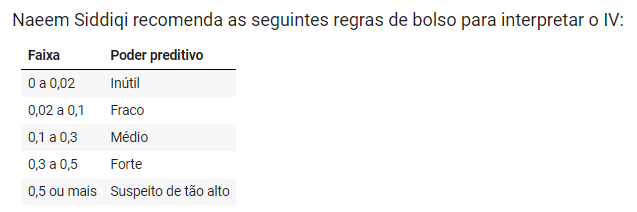

## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

### As variáveis que parecem ser mais significativas no quesito IV são:
##  - Categoria
##  - Q_10
##  - Q_20
##  - Q_50

## Quando realizamos uma categorização, utilizando o QCUT nesse caso, parece que quanto maior o número de quartis informados, maior o valor do "Information Value".

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

In [20]:
df_1.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,...,dia_da_semana,dia_da_semana_numeral,mês,dia_do_mês,dia_útil,fim_de_semana,Q_5,Q_10,Q_20,Q_50
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(13.36, 28.61]","(20.29, 28.61]","(24.5, 28.61]","(23.62, 25.14]"
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(28.61, 55.0]","(38.88, 55.0]","(46.028, 55.0]","(48.0, 50.72]"
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(13.36, 28.61]","(20.29, 28.61]","(24.5, 28.61]","(26.9, 28.61]"
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(55.0, 131.36]","(81.8, 131.36]","(101.48, 131.36]","(107.04, 119.5]"
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(55.0, 131.36]","(81.8, 131.36]","(101.48, 131.36]","(119.5, 131.36]"


In [21]:
qt_notas_trimestre = df_1.groupby('trimestre')['Data Registro'].count()
qt_notas_trimestre = pd.DataFrame(qt_notas_trimestre)
qt_notas_trimestre = qt_notas_trimestre.reset_index()
qt_notas_trimestre.head()

,trimestre,Data Registro
0,1,42441
1,2,43089
2,3,51224
3,4,50892


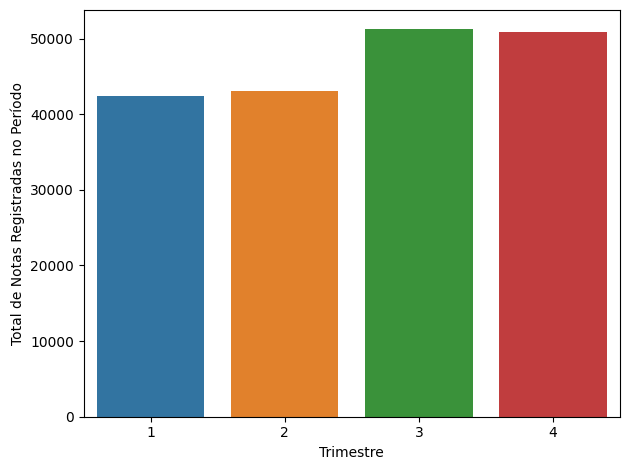

In [22]:
#criando uma figure, axes
fig, ax = plt.subplots()
#criando o gráfico de barras
sns.barplot(x=qt_notas_trimestre['trimestre'], y=qt_notas_trimestre['Data Registro'], ax=ax, data=qt_notas_trimestre)
plt.xlabel('Trimestre')
plt.ylabel('Total de Notas Registradas no Período')
#otimizar espaço da figure
fig.tight_layout();

In [23]:
qt_notas_categoria = df_1.groupby(['trimestre','categoria'])['Data Registro'].count()
qt_notas_categoria = pd.DataFrame(qt_notas_categoria)

qt_notas_categoria = qt_notas_categoria.reset_index()
qt_notas_categoria.head()

,trimestre,categoria,Data Registro
0,1,Alimentos,3686
1,1,Auto posto,1040
2,1,Construção,7296
3,1,Farmácia,3523
4,1,Mercado,9728


**Primeiro agrupamos por trimestre no qt_notas_trimestre:**

In [36]:
trimestre_totais = qt_notas_trimestre.groupby('trimestre')['Data Registro'].sum().to_dict()

In [37]:
trimestre_totais

{1: 42441, 2: 43089, 3: 51224, 4: 50892}

**Iterando sobre qt_notas_categoria e calculando a porcentagem:**

In [40]:
for index, row in qt_notas_categoria.iterrows():
  trimestre_total = trimestre_totais.get(row['trimestre'], 0)
  if trimestre_total > 0:
    qt_notas_categoria.at[index, 'tx%'] = (row['Data Registro'] / trimestre_total) * 100
  else:
    qt_notas_categoria.at[index, 'tx%'] = 0
qt_notas_categoria.head(50)

,trimestre,categoria,Data Registro,tx%
0,1,Alimentos,3686,8.684998
1,1,Auto posto,1040,2.450461
2,1,Construção,7296,17.190924
3,1,Farmácia,3523,8.300935
4,1,Mercado,9728,22.921232
5,1,Restaurantes,9693,22.838764
6,1,Varejo,1076,2.535284
7,1,Vestuário,646,1.522113
8,1,não definido,5753,13.555289
9,2,Alimentos,4745,11.012091


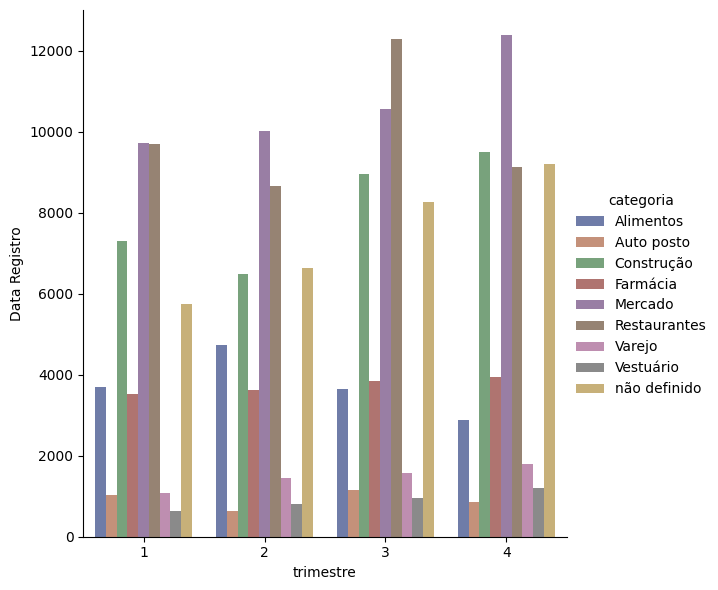

In [41]:
# Draw a nested barplot by species and sex
ax = sns.catplot(
    data=qt_notas_categoria, kind="bar",
    x="trimestre", y="Data Registro", hue="categoria",
    errorbar="sd", palette="dark", alpha=.6, height=6
)

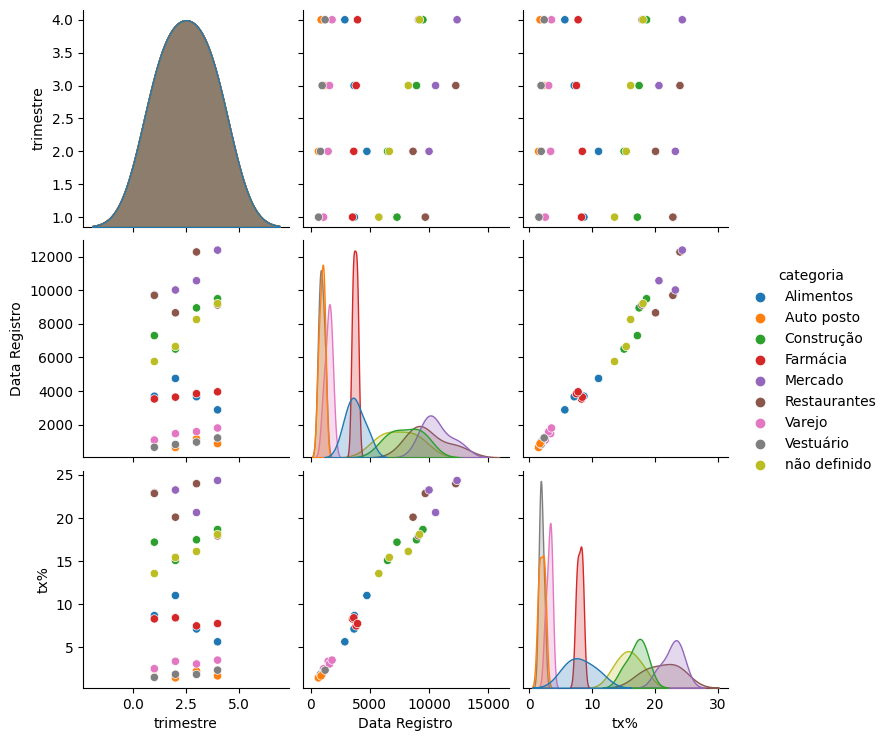

In [42]:
# Criando o gráfico de barras com kind="bar" e ci=None
sns.pairplot(qt_notas_categoria, hue="categoria")

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [43]:
df_1.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,...,dia_da_semana,dia_da_semana_numeral,mês,dia_do_mês,dia_útil,fim_de_semana,Q_5,Q_10,Q_20,Q_50
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(13.36, 28.61]","(20.29, 28.61]","(24.5, 28.61]","(23.62, 25.14]"
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(28.61, 55.0]","(38.88, 55.0]","(46.028, 55.0]","(48.0, 50.72]"
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(13.36, 28.61]","(20.29, 28.61]","(24.5, 28.61]","(26.9, 28.61]"
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(55.0, 131.36]","(81.8, 131.36]","(101.48, 131.36]","(107.04, 119.5]"
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,...,Sexta-feira,4,6,30,1,0,"(55.0, 131.36]","(81.8, 131.36]","(101.48, 131.36]","(119.5, 131.36]"


In [81]:
tab = df_1[['flag_credito', 'categoria', 'Data Registro', 'Ano', 'Créditos', 'mês']]
tab = pd.DataFrame(tab)

In [82]:
tab_20_21 = tab[tab["Data Registro"].isin(pd.date_range("2020-01-01", "2021-01-07"))]
tab_20_21.head()

,flag_credito,categoria,Data Registro,Ano,Créditos,mês
64598,0,não definido,2020-08-01,2019,0.0,1
64599,0,Mercado,2020-01-01,2019,0.0,1
64600,0,Alimentos,2020-08-01,2019,0.0,1
64601,0,Farmácia,2020-08-01,2019,0.0,1
64602,0,Restaurantes,2020-08-01,2019,0.0,1


In [83]:
tab_20_21.groupby(['Data Registro', 'categoria'])[['flag_credito']].sum()

flag_credito
Data Registro categoria                 
2020-01-01    Farmácia                 0
              Mercado                  0
2020-01-02    Alimentos                8
              Construção              11
              Farmácia                 3
...                                  ...
2021-01-07    Mercado                 18
              Restaurantes             4
              Varejo                   2
              Vestuário                3
              não definido            10

[3037 rows x 1 columns]

In [84]:
cat_flag = tab_20_21.groupby(['Data Registro', 'categoria'])[['flag_credito']].sum()

In [85]:
cat_flag['evento_total'] =  tab_20_21.groupby(['Data Registro', 'categoria'])[['flag_credito']].count()
cat_flag['evento_sim'] = cat_flag['flag_credito']
cat_flag['evento_não'] = cat_flag['evento_total'] - cat_flag['evento_sim']
cat_flag['prop_sim'] = cat_flag['evento_sim'] / cat_flag['evento_total']
cat_flag['prop_não'] = cat_flag['evento_não'] / cat_flag['evento_total']
cat_flag = cat_flag.drop(columns=['flag_credito'])
cat_flag.sort_values(by=['prop_sim'], ascending=False)


evento_total  evento_sim  evento_não  prop_sim  \
Data Registro categoria                                                      
2020-02-14    Restaurantes             5           5           0       1.0   
2020-02-02    Auto posto               1           1           0       1.0   
2020-06-10    Alimentos                5           5           0       1.0   
2020-08-09    Restaurantes             3           3           0       1.0   
2020-03-09    Restaurantes             1           1           0       1.0   
...                                  ...         ...         ...       ...   
2020-10-02    Varejo                   1           0           1       0.0   
2020-04-02    Vestuário                1           0           1       0.0   
              Varejo                  12           0          12       0.0   
2020-10-03    Auto posto               2           0           2       0.0   
2020-01-01    Farmácia                 4           0           4       0.0   

                            prop_não  
Data Registro categoria               
2020-02-14    Restaurantes       0.0  
2020-02-02    Auto posto         0.0  
2020-06-10    Alimentos          0.0  
2020-08-09    Restaurantes       0.0  
2020-03-09    Restaurantes       0.0  
...                              ...  
2020-10-02    Varejo             1.0  
2020-04-02    Vestuário          1.0  
              Varejo             1.0  
2020-10-03    Auto posto         1.0  
2020-01-01    Farmácia           1.0  

[3037 rows x 5 columns]

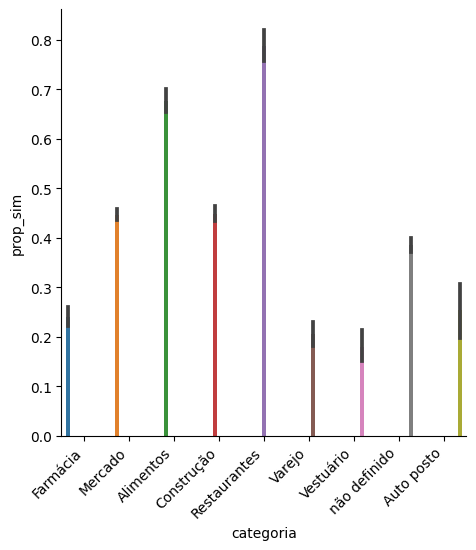

In [87]:
ax = sns.catplot(
    data=cat_flag.reset_index(), kind="bar",
    x="categoria", y="prop_sim", hue="categoria",
)
plt.xticks(rotation=45, ha='right');
plt.show()

In [95]:
tab_plotly = tab_20_21.groupby(['Data Registro', 'categoria'])[['flag_credito']].sum()
tab_plotly['evento_total'] = tab_20_21.groupby(['Data Registro', 'categoria'])[['flag_credito']].count()

In [96]:
tab_plotly = tab_plotly.rename(columns={'flag_credito':'evento_sim'})

In [97]:
tab_plotly['evento_não']= tab_plotly['evento_total'] - tab_plotly['evento_sim']

In [98]:
tab_plotly

evento_sim  evento_total  evento_não
Data Registro categoria                                         
2020-01-01    Farmácia               0             4           4
              Mercado                0             2           2
2020-01-02    Alimentos              8             9           1
              Construção            11            20           9
              Farmácia               3             9           6
...                                ...           ...         ...
2021-01-07    Mercado               18            38          20
              Restaurantes           4             5           1
              Varejo                 2             4           2
              Vestuário              3             5           2
              não definido          10            23          13

[3037 rows x 3 columns]

In [99]:
tab_plotly = tab_plotly.rename(columns={"evento_sim": "sim", "evento_não": "nao", "evento_total": "N"})

In [100]:
tab_plotly['tx_evento'] = tab_plotly.sim/tab_plotly.N

In [101]:
rotulo_ev, rotulo_nev = ('sim', 'nao')

tab_plotly['pct_evento']     = tab_plotly[rotulo_ev]/tab_plotly[rotulo_ev].groupby(level=0).sum()
tab_plotly['pct_nao_evento'] = tab_plotly[rotulo_nev]/tab_plotly[rotulo_nev].groupby(level=0).sum()
tab_plotly['WOE'] = np.log(tab_plotly.pct_evento/tab_plotly.pct_nao_evento)
tab_plotly.head(100)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


sim   N  nao  tx_evento  pct_evento  pct_nao_evento  \
Data Registro categoria                                                         
2020-01-01    Farmácia      0   4    4   0.000000         NaN        0.666667   
              Mercado       0   2    2   0.000000         NaN        0.333333   
2020-01-02    Alimentos     8   9    1   0.888889    0.145455        0.015625   
              Construção   11  20    9   0.550000    0.200000        0.140625   
              Farmácia      3   9    6   0.333333    0.054545        0.093750   
...                       ...  ..  ...        ...         ...             ...   
2020-01-13    Alimentos    11  11    0   1.000000    0.215686        0.000000   
              Auto posto    1   1    0   1.000000    0.019608        0.000000   
              Construção    9  16    7   0.562500    0.176471        0.140000   
              Farmácia      1  16   15   0.062500    0.019608        0.300000   
              Mercado      14  27   13   0.518519    0.274510        0.260000   

                               WOE  
Data Registro categoria             
2020-01-01    Farmácia         NaN  
              Mercado          NaN  
2020-01-02    Alimentos   2.230991  
              Construção  0.352221  
              Farmácia   -0.541597  
...                            ...  
2020-01-13    Alimentos        inf  
              Auto posto       inf  
              Construção  0.231512  
              Farmácia   -2.727853  
              Mercado     0.054305  

[100 rows x 7 columns]

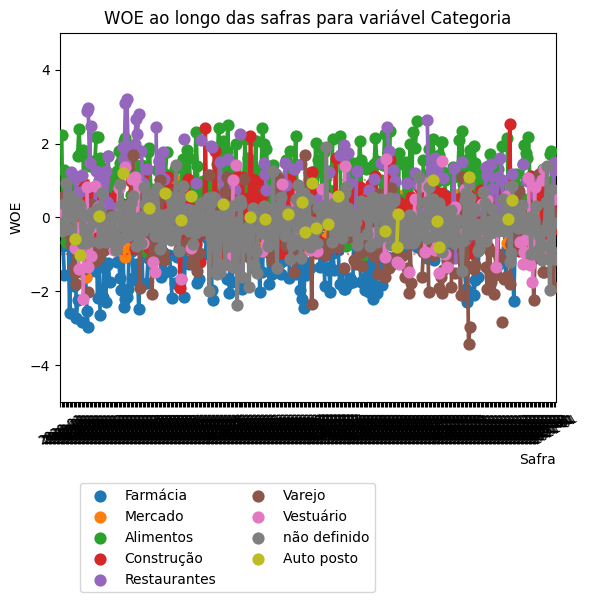

In [110]:
fig, ax = plt.subplots()
variavel='categoria'

# Comando principal do gráfico
sns.pointplot(data=tab_plotly.reset_index(), y = 'WOE', x = 'Data Registro', hue=variavel, ax=ax);

# Rotacionar os rótulos do eixo X
labs = tab_plotly.index.get_level_values(level=0).unique()
labs2 = [x.to_period('M') for x in labs]

ax.set_xticklabels(labs2,rotation=30, fontsize='small')
ax.legend(bbox_to_anchor=(.65, -.2), ncol=2)

#limites do gráfico - mostrando 1 e -1 para ter referência
ymax = max(5, max(tab_plotly.WOE))
ymin = min(-5, min(tab_plotly.WOE))
ax.set_ylim([ymin, ymax])

# Linhas de referência
ax.axhline(1, linestyle=':'  , color='red', alpha=.5)
ax.axhline(0, linestyle='--' , color='grey', alpha=.5)
ax.axhline(-1, linestyle=':' , color='red', alpha=.5)

# Títulos
ax.set_title(f'WOE ao longo das safras para variável {variavel.capitalize()}')
ax.set_xlabel('Safra', loc='right');

In [106]:
((tab_plotly.pct_evento - tab_plotly.pct_nao_evento)*tab_plotly.WOE)

Data Registro  categoria   
2020-01-01     Farmácia             NaN
               Mercado              NaN
2020-01-02     Alimentos       0.289649
               Construção      0.020913
               Farmácia        0.021233
                                 ...   
2021-01-07     Mercado         0.000006
               Restaurantes    0.069756
               Varejo          0.000293
               Vestuário       0.009142
               não definido    0.004292
Length: 3037, dtype: float64

In [103]:
iv_cat = ((tab_plotly.pct_evento - tab_plotly.pct_nao_evento)*tab_plotly.WOE).groupby(level=0).sum();


In [104]:
iv_cat

Data Registro
2020-01-01    0.000000
2020-01-02    0.430608
2020-01-03         NaN
2020-01-04         NaN
2020-01-05         NaN
                ...   
2021-01-03         NaN
2021-01-04         NaN
2021-01-05         NaN
2021-01-06         NaN
2021-01-07         NaN
Length: 373, dtype: float64

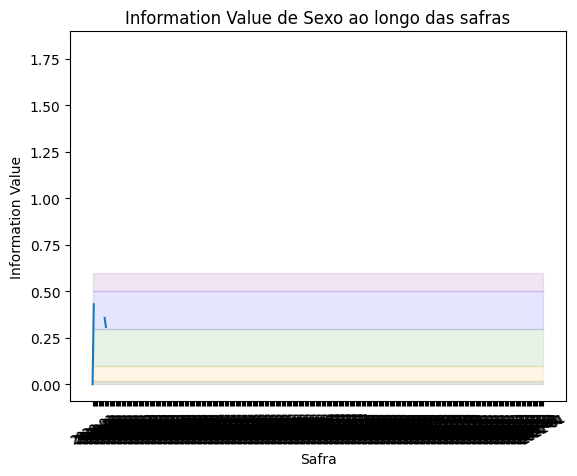

In [108]:
def plot_iv(IV):
    fig, ax = plt.subplots()
    x = IV.index
    a = [.02]*len(IV.index)
    b = [.1]*len(IV.index)
    c = [.3]*len(IV.index)
    d = [.5]*len(IV.index)
    e = [.6]*len(IV.index)

    ax.fill_between(IV.index, a, color='grey', alpha=.2)
    ax.fill_between(IV.index, a, b, color='orange', alpha=.1)
    ax.fill_between(IV.index, b, c, color='green', alpha=.1)
    ax.fill_between(IV.index, c, d, color='blue', alpha=.1)
    ax.fill_between(IV.index, d, e, color='purple', alpha=.1)
    ax.plot(IV)

    labs = IV.index.get_level_values(level=0).unique()
    labs2 = [x.to_period('M') for x in labs]

    ax.set_xticks(labs)
    ax.set_xticklabels(labs2,rotation=30, fontsize='small')

    ax.set_title("Information Value de Sexo ao longo das safras")
    ax.set_ylabel("Information Value")
    ax.set_xlabel("Safra")

plot_iv(iv_cat)

In [71]:
iv_cat

TypeError: ignored

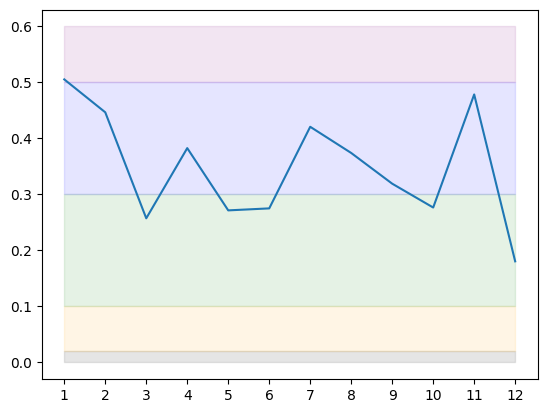

In [73]:
def plot_iv(IV):
    fig, ax = plt.subplots()
    x = IV.index
    a = [.02]*len(IV.index)
    b = [.1]*len(IV.index)
    c = [.3]*len(IV.index)
    d = [.5]*len(IV.index)
    e = [.6]*len(IV.index)

    ax.fill_between(IV.index, a, color='grey', alpha=.2)
    ax.fill_between(IV.index, a, b, color='orange', alpha=.1)
    ax.fill_between(IV.index, b, c, color='green', alpha=.1)
    ax.fill_between(IV.index, c, d, color='blue', alpha=.1)
    ax.fill_between(IV.index, d, e, color='purple', alpha=.1)
    ax.plot(IV)

    labs = IV.index.get_level_values(level=0).unique()
    labs2 = [x.to_period('M') for x in labs]

    ax.set_xticks(labs)
    ax.set_xticklabels(labs2,rotation=30, fontsize='small')

    ax.set_title("Information Value de Sexo ao longo das safras")
    ax.set_ylabel("Information Value")
    ax.set_xlabel("Safra")

plot_iv(iv_cat)

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

## Analisando as tabelas e gráficos acima, podemos verificar que as maiores porcentagens de créditos nas NFe são gerados nas categorias de restaurantes, alimentos e mercado. A construção civil fica praticamente empatado com os mercados na geração de créditos. Os dados analisados ficam compreendidos no período a partir de janeiro de 2020.